In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance_train(df, num_fol):
  generate_more_data(df, num_fol)
  aug_df = create_df_more(num_fol)
  new_df = pd.concat([df, aug_df], ignore_index=True)
  return new_df
# make_balance_train(train_df.loc[train_idx])

In [8]:
def min_len_arr(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  return minlenarr
# print(min_len_arr(train_df.loc[train_idx]))

def generate_more_data(df, num_fol):
    gene = ImageDataGenerator(brightness_range=[0.2,2.0],vertical_flip=True,shear_range=20)
    len_disea = min_len_arr(df)
    print(len_disea)
    max_disea = max(len_disea)
#     print(max_disea)
    for i in type_disea:
        num_of_disea = len_disea[type_disea.index(i)]
        cur_path = os.path.join(f'/kaggle/working/more_img{num_fol}',i)
        create_img = gene.flow_from_dataframe(df.loc[df['labels']==i], x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=1, save_to_dir=cur_path, save_format='jpg')
        if i == type_disea[len_disea.index(max_disea)]: pass
        else:
            for j in range(0, max_disea-num_of_disea):
              hh = next(create_img)       
# generate_more_data(train_df.loc[train_idx],1)

def create_df_more(num_fol):
  filepaths, labels = [],[]
  data_path = f'/kaggle/working/more_img{num_fol}'
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
#   print(df)
  return df

In [9]:
def create_fol(n):
  os.makedirs(f'/kaggle/working/more_img{n}', exist_ok=True)
  for i in type_disea:
    os.makedirs(os.path.join(f'/kaggle/working/more_img{n}', i), exist_ok=True)

[119, 65, 106, 128]
Found 119 validated image filenames belonging to 1 classes.
Found 65 validated image filenames belonging to 1 classes.
Found 106 validated image filenames belonging to 1 classes.
Found 128 validated image filenames belonging to 1 classes.
Found 512 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726981921.231795     101 service.cc:145] XLA service 0x7dc2280021d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726981921.231861     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726982016.925026     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.5225 - loss: 1.2052 - val_accuracy: 0.6476 - val_loss: 1.2967
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9014 - loss: 0.2529 - val_accuracy: 0.6857 - val_loss: 1.2516
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9742 - loss: 0.0888 - val_accuracy: 0.7810 - val_loss: 0.7941
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9753 - loss: 0.0520 - val_accuracy: 0.8952 - val_loss: 0.2763
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9743 - loss: 0.0575 - val_accuracy: 0.9524 - val_loss: 0.2879
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9929 - loss: 0.0300 - val_accuracy: 0.9619 - val_loss: 0.0955
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9813 - loss: 0.0587 - val_accuracy: 0.9619 - val_loss: 0.1131
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9967 - loss: 0.0173 - val_accuracy: 0.9524 - val_loss: 0.3019
Ep

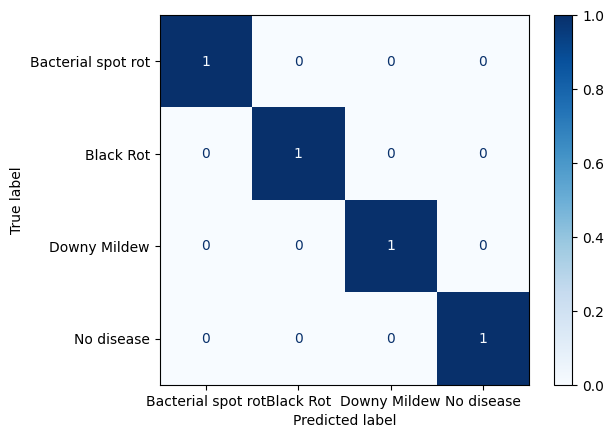

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       1.00      1.00      1.00        36
        No disease       1.00      1.00      1.00        42

          accuracy                           1.00       133
         macro avg       1.00      1.00      1.00       133
      weighted avg       1.00      1.00      1.00       133

[109, 63, 117, 129]
Found 109 validated image filenames belonging to 1 classes.
Found 63 validated image filenames belonging to 1 classes.
Found 117 validated image filenames belonging to 1 classes.
Found 129 validated image filenames belonging to 1 classes.
Found 516 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5088 - loss: 1.2576

I0000 00:00:1726982958.669473     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_456', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_454', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_452', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 36 bytes spill stores, 36 bytes spill loads



17/17 ━━━━━━━━━━━━━━━━━━━━ 286s 9s/step - accuracy: 0.5268 - loss: 1.2139 - val_accuracy: 0.6857 - val_loss: 1.1092
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9370 - loss: 0.1846 - val_accuracy: 0.8667 - val_loss: 0.4412
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9685 - loss: 0.0937 - val_accuracy: 0.9524 - val_loss: 0.1988
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9544 - loss: 0.1266 - val_accuracy: 0.9810 - val_loss: 0.1399
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9853 - loss: 0.0538 - val_accuracy: 0.9905 - val_loss: 0.1226
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9851 - loss: 0.0412 - val_accuracy: 0.9905 - val_loss: 0.1226
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9934 - loss: 0.0318 - val_accuracy: 0.9905 - val_loss: 0.1335
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9826 - loss: 0.0520 - val_accuracy: 0.9905 - val_loss: 0.1545
Ep

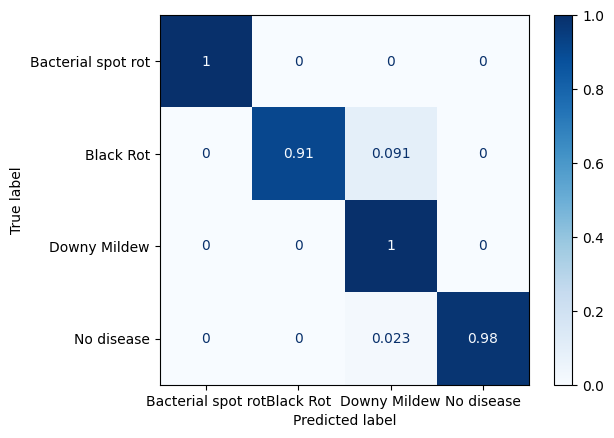

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.91      0.95        22
      Downy Mildew       0.92      1.00      0.96        33
        No disease       1.00      0.98      0.99        43

          accuracy                           0.98       133
         macro avg       0.98      0.97      0.97       133
      weighted avg       0.98      0.98      0.98       133

[112, 61, 112, 133]
Found 112 validated image filenames belonging to 1 classes.
Found 61 validated image filenames belonging to 1 classes.
Found 112 validated image filenames belonging to 1 classes.
Found 133 validated image filenames belonging to 1 classes.
Found 532 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 278s 9s/step - accuracy: 0.5297 - loss: 1.2162 - val_accuracy: 0.3048 - val_loss: 4.1123
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9263 - loss: 0.2084 - val_accuracy: 0.5524 - val_loss: 2.1572
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9699 - loss: 0.0909 - val_accuracy: 0.8000 - val_loss: 0.7891
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9628 - loss: 0.1069 - val_accuracy: 0.8476 - val_loss: 0.5244
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9786 - loss: 0.1081 - val_accuracy: 0.9619 - val_loss: 0.1256
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9934 - loss: 0.0203 - val_accuracy: 0.9905 - val_loss: 0.0733
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9880 - loss: 0.0448 - val_accuracy: 0.9905 - val_loss: 0.0404
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9915 - loss: 0.0486 - val_accuracy: 0.9905 - val_loss: 0.0363
Ep

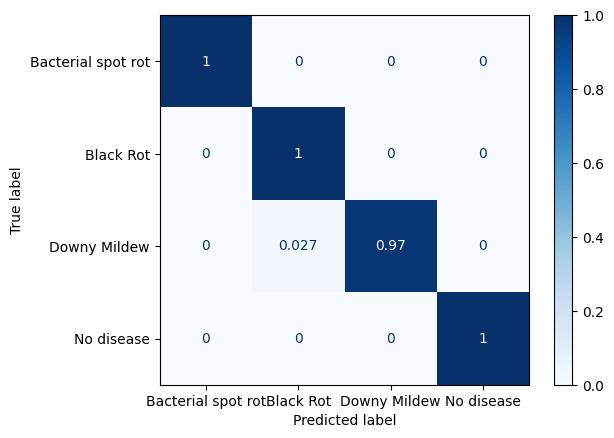

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       0.95      1.00      0.97        19
      Downy Mildew       1.00      0.97      0.99        37
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

[113, 64, 107, 135]
Found 113 validated image filenames belonging to 1 classes.
Found 64 validated image filenames belonging to 1 classes.
Found 107 validated image filenames belonging to 1 classes.
Found 135 validated image filenames belonging to 1 classes.
Found 540 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 283s 9s/step - accuracy: 0.5869 - loss: 1.1190 - val_accuracy: 0.7308 - val_loss: 0.5402
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9279 - loss: 0.2383 - val_accuracy: 0.9038 - val_loss: 0.2259
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9578 - loss: 0.1276 - val_accuracy: 0.9712 - val_loss: 0.1036
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9644 - loss: 0.1295 - val_accuracy: 0.9712 - val_loss: 0.0664
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9680 - loss: 0.0812 - val_accuracy: 0.9904 - val_loss: 0.0492
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9855 - loss: 0.0358 - val_accuracy: 0.9904 - val_loss: 0.0345
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9828 - loss: 0.0395 - val_accuracy: 0.9904 - val_loss: 0.0166
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9986 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0053
Ep

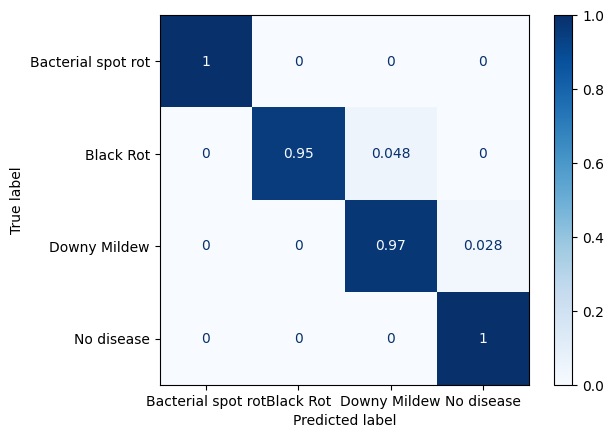

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      0.97      0.97        36
        No disease       0.98      1.00      0.99        41

          accuracy                           0.98       133
         macro avg       0.99      0.98      0.98       133
      weighted avg       0.99      0.98      0.98       133

[111, 67, 110, 131]
Found 111 validated image filenames belonging to 1 classes.
Found 67 validated image filenames belonging to 1 classes.
Found 110 validated image filenames belonging to 1 classes.
Found 131 validated image filenames belonging to 1 classes.
Found 524 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.4563 - loss: 1.4254 - val_accuracy: 0.7308 - val_loss: 0.7237
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9066 - loss: 0.2425 - val_accuracy: 0.8750 - val_loss: 0.5058
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9789 - loss: 0.0823 - val_accuracy: 0.8077 - val_loss: 0.5812
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9658 - loss: 0.0869 - val_accuracy: 0.8942 - val_loss: 0.3863
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9856 - loss: 0.0424 - val_accuracy: 0.9038 - val_loss: 0.3338
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9968 - loss: 0.0159 - val_accuracy: 0.9327 - val_loss: 0.2496
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9838 - loss: 0.0397 - val_accuracy: 0.9231 - val_loss: 0.2449
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9928 - loss: 0.0247 - val_accuracy: 0.9327 - val_loss: 0.2005
Ep

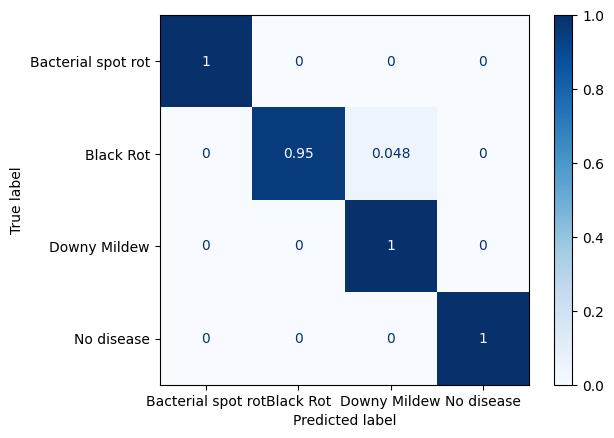

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133



In [10]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])

epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  create_fol(i) 
  a = make_balance_train(train_df.loc[train_idx], i)
  b = train_df.loc[valid_idx]
  train = gen.flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)